In [ ]:
from utils.distributions_sampling_util import *
from utils.plots_util import *
from utils.fits_util import *
import timeit
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

In [8]:
import os
os.environ["PATH"] += os.pathsep + "/usr/local/texlive/2024/bin/universal-darwin"


In [9]:
plt.style.use('latex_style.mplstyle')

# **Parameter Testing and Extended Likelihood Fit**

This section defines the **true model parameters**, tests multiple sets of parameter variations for normalization, and performs the following steps:

1. **Normalization Testing**: Ensure the defined signal and background PDFs integrate correctly over their respective domains.
2. **Distribution Visualization**: Compare the theoretical PDFs with sampled distributions.
3. **Sample Generation**: Generate $100,000$ samples from the joint signal-background model.
4. **Extended Likelihood Fit**: Perform a fit to recover the model parameters using `iminuit` with specified bounds and initial guesses.

---

## **True Parameters and Variations**

The true model parameters are:

$$
\mu = 3, \, \sigma = 0.3, \, \beta = 1, \, m = 1.4, \, \lambda_s = 0.3, \, \mu_b = 0, \, \sigma_b = 2.5, \, f_{\text{signal}} = 0.6
$$

To test normalization robustness, five parameter sets are defined:

1. **True Parameters**: $[3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]$
2. **Slight Variation 1**: $[2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]$
3. **Slight Variation 2**: $[3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5]$
4. **Increased Deviations**: $[3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65]$
5. **Lower Bound Variation**: $[2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]$

---

## **Parameter Bounds**

To ensure stability during the fit, the following bounds are applied to each parameter:

| **Parameter**           | **Description**                                 | **Bounds**             |
|-------------------------|-------------------------------------------------|------------------------|
| $\mu$                   | Mean of $g_s(X)$                                | $[2.8, 3.2]$           |
| $\sigma$                | Width of Gaussian core in $g_s(X)$              | $[0.05, 0.5]$          |
| $\beta$                 | Transition point to power-law tail              | $[0.5, 1.5]$           |
| $m$                     | Slope of power-law tail in $g_s(X)$             | $[1.0, 2.0]$           |
| $\lambda_s$             | Decay constant for $h_s(Y)$                     | $[0.1, 1.0]$           |
| $\mu_b$                 | Mean of background $h_b(Y)$                     | $[-1, 1]$              |
| $\sigma_b$              | Width of background $h_b(Y)$                    | $[2.0, 4.0]$           |
| $f_{\text{signal}}$     | Signal fraction                                 | $[0.1, 0.9]$           |
| $N_{\text{expected}}$   | Total number of events                          | $[75,000, 125,000]$    |

---

## **Steps in the Code**

1. **Test Normalization**:
   - For each parameter set, verify that the component PDFs integrate to $1$.
   - Output the integral results for $g_s(X), h_s(Y), g_b(X), h_b(Y)$, and the joint $f(X, Y)$.

2. **Visualize Theoretical Distributions**:
   - Plot the **marginal distributions** $g_s(X), g_b(X)$ and $h_s(Y), h_b(Y)$.
   - Compare the combined theoretical distributions with the generated samples.

3. **Sample Generation**:
   - Generate $100,000$ samples from the joint distribution $f(X, Y)$.

4. **Perform Extended Likelihood Fit**:
   - Initialize the fit using `iminuit` with the bounds and an initial guess.
   - Report the fitted parameters and their uncertainties.
   - Print Minuit diagnostics to ensure convergence.

---

## **Output**

- **Normalization Results** for each parameter set.
- Plots of:
   1. **Theoretical Marginal Distributions** in $X$ and $Y$.
   2. **Sampled Distributions** overlaid with the theoretical curves.
   3. **2D Joint Distribution** of $f(X, Y)$.
- **Fit Results**: Recovered parameters, uncertainties, and diagnostics.


Normalization Test Results:

Parameter Set 1: [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 2: [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 3: [3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 4: [3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 5: [2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Generating distribution plots for params_true...


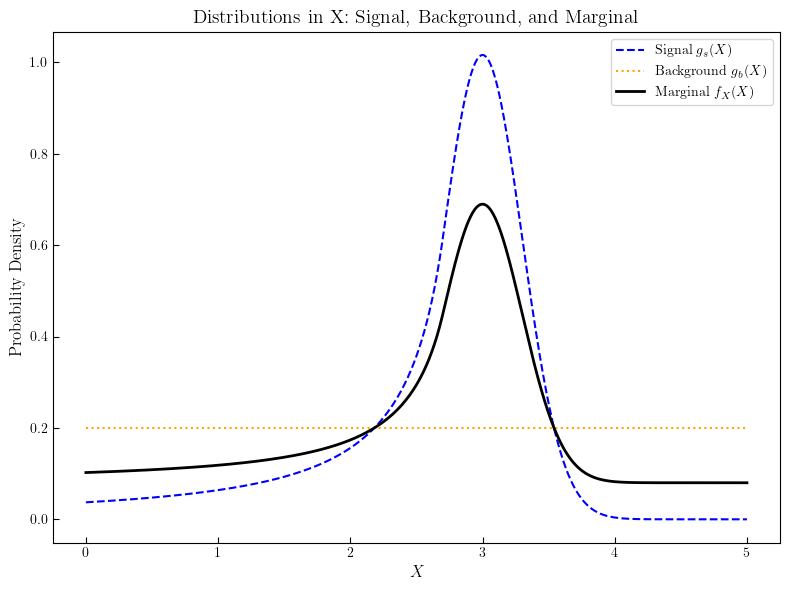

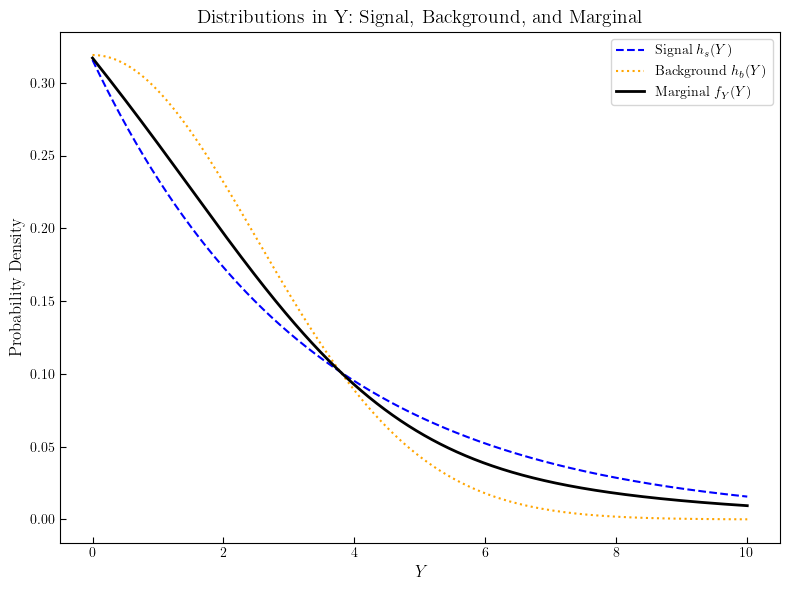

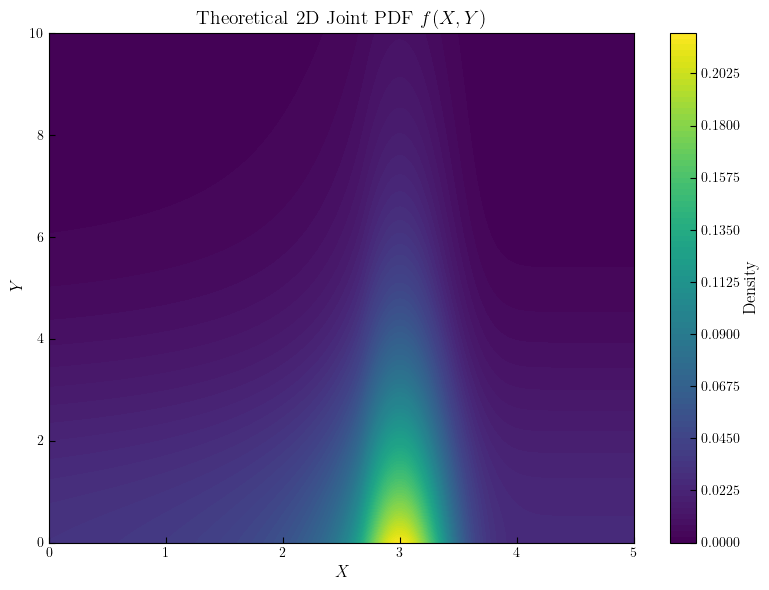


Generating sampled distribution plots...


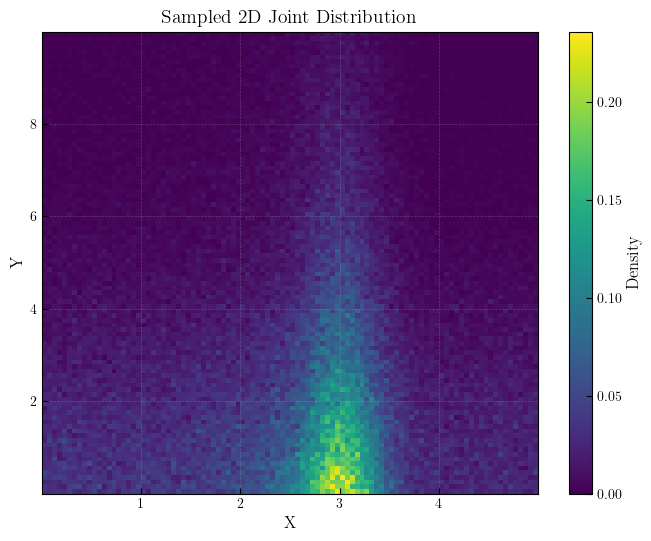

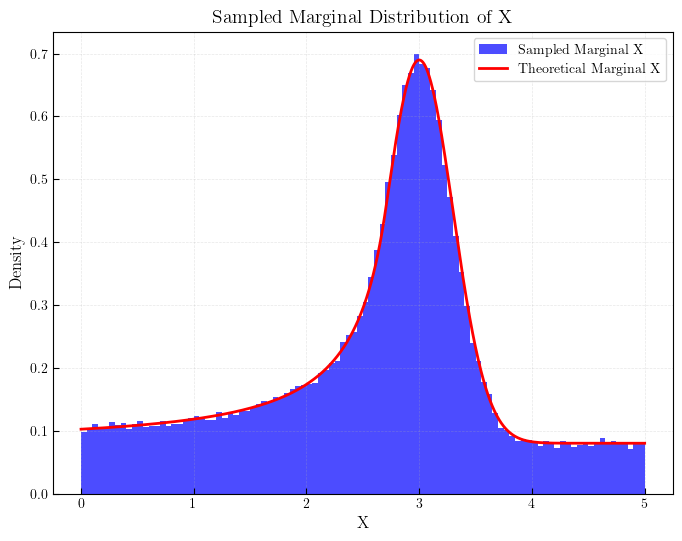

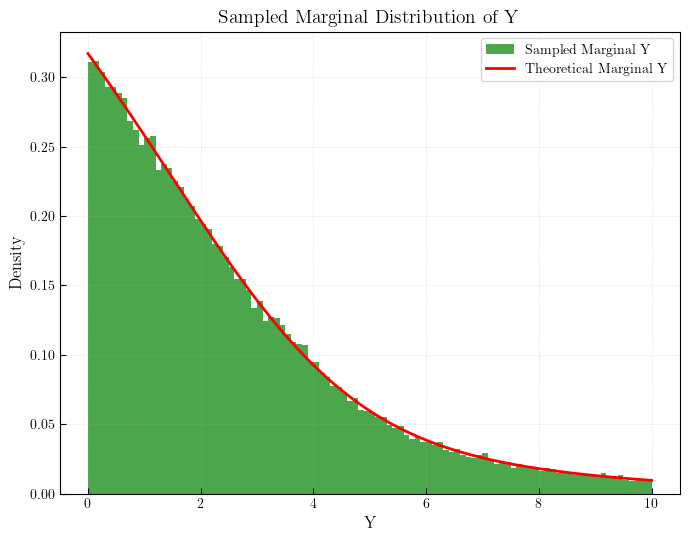

Fit converged successfully.
Fitted parameters: {'mu': 2.992825422394197, 'sigma': 0.30138455729113456, 'beta': 1.0208159838823403, 'm': 1.3418449541487676, 'lambda_s': 0.30114326139482517, 'mu_b': 0.13753663440554686, 'sigma_b': 2.4335417063927895, 'f_signal': 0.6037287360059166, 'N_expected': 100000.11321456796}
Uncertainties: {'mu': 0.0036703118675771584, 'sigma': 0.0034730437832983796, 'beta': 0.03322254262159041, 'm': 0.0879058922899778, 'lambda_s': 0.0028971923554299284, 'mu_b': 0.1081712525458729, 'sigma_b': 0.05200815967888772, 'f_signal': 0.005041309432582519, 'N_expected': 447.1903042432532}

Fit successful! Fitted parameters:
  mu: 2.9928
  sigma: 0.3014
  beta: 1.0208
  m: 1.3418
  lambda_s: 0.3011
  mu_b: 0.1375
  sigma_b: 2.4335
  f_signal: 0.6037
  N_expected: 100000.1132

Minuit Fit Diagnostics:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├─────────────────────────

In [10]:
# Parameters for testing
params_true = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
params_normalization = [
    params_true,
    [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7],   # Slight variation 1
    [3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5],  # Slight variation 2
    [3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65], # Slightly increased deviations
    [2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]  # Lower bound variation
]
# Corrected bounds definition
bounds = {
    "mu": (2.8, 3.2),
    "sigma": (0.05, 0.5),
    "beta": (0.5, 1.5),
    "m": (1.0, 2.0),
    "lambda_s": (0.1, 1.0),
    "mu_b": (-1, 1),
    "sigma_b": (2.0, 4.0),
    "f_signal": (0.1, 0.9),
    "N_expected": (0.75 * 100000, 1.25 * 100000)
}

# Step 1: Test normalization for each parameter set
print("Normalization Test Results:")
for i, params in enumerate(params_normalization):
    results = test_normalization(params, 10000)  # Call the test_normalization function for each parameter set
    print(f"\nParameter Set {i + 1}: {params}")
    for dist, value in results.items():
        print(f"  {dist}: {value:.6f}")

# Step 2: Plot distributions for params_true
print("\nGenerating distribution plots for params_true...")
plot_distributions(params_true)

x_samples, y_samples = sample_componentwise(100000, params_true)

# Step 4: Plot sampled distributions
print("\nGenerating sampled distribution plots...")
plot_sampled_distributions(x_samples, y_samples, params_true)
# Define initial guesses and bounds for the fit
initial_guess = {
    "mu": 3.0,
    "sigma": 0.3,
    "beta": 1.0,
    "m": 1.4,
    "lambda_s": 0.3,
    "mu_b": 0.0,
    "sigma_b": 2.5,
    "f_signal": 0.6,
    "N_expected": 100000
}

# Perform the fit and retrieve Minuit object
fit_result, m = perform_fit(x_samples, y_samples, bounds, initial_guess, return_minuit=True)

if fit_result["converged"]:
    print("\nFit successful! Fitted parameters:")
    for param, value in fit_result["parameters"].items():
        print(f"  {param}: {value:.4f}")
    
    # Display Minuit diagnostics
    print("\nMinuit Fit Diagnostics:")
    print(m)

else:
    print("\nFit failed. Cannot generate surface comparison or diagnostics.")


## Benchmarking Execution Times

This section benchmarks the execution times for three key processes involved in the workflow:

1. **Random Sampling** (`np.random.normal`): Baseline random number generation for comparison.
2. **Componentwise Sample Generation**: Sampling data from the defined **signal** and **background distributions**.
3. **Maximum Likelihood Fit**: Performing the extended likelihood fit to estimate model parameters using the generated samples.

### **Purpose**
- Measure the computational efficiency of each task.
- Compare relative execution times against a baseline (`np.random.normal`).
- Assess variability in execution times using average values and standard deviations.

---

### **Benchmarking Method**
1. **Repeated Timing**: Each task is timed **100 times** (configurable using `n_calls`).
   - Timing is performed using `timeit.repeat` for precision and consistency.
2. **Tasks Measured**:
   - **Task 1**: `np.random.normal` baseline random sampling.
   - **Task 2**: Componentwise sample generation using the signal and background distributions.
   - **Task 3**: Maximum likelihood fit using `perform_fit`.

3. **Performance Metrics**:
   - **Average Time**: Mean execution time (seconds) over all repetitions.
   - **Standard Deviation**: Variability in execution times across repetitions.
   - **Relative Time**: Execution time normalized relative to the baseline (`np.random.normal`).

---

### **Results**
The results are presented in a **tabular format** with the following columns:
| **Task**                  | **Average Time (s)** | **Std Dev (s)** | **Relative Time** |
|---------------------------|----------------------|-----------------|------------------|
| `np.random.normal`        | Baseline             | Variability     | 1.00             |
| Componentwise Sampling    | Time for sample gen  | Variability     | Relative to baseline |
| Maximum Likelihood Fit    | Time for fitting     | Variability     | Relative to baseline |




In [ ]:
def time_benchmark(bounds, initial_guess, params, size=100000, n_calls=100):
    """
    Benchmark execution times for:
    1. np.random.normal
    2. Componentwise sample generation
    3. Maximum likelihood fitting using generated samples

    Parameters:
    - bounds: Bounds for parameter fitting.
    - initial_guess: Initial parameter guesses for the fit.
    - params: True model parameters used for sampling.
    - size: Number of events to generate.
    - n_calls: Number of calls to average for benchmarking.

    Returns:
    - DataFrame containing times and relative times with std deviations.
    """
    # 1. Benchmark np.random.normal
    normal_times = timeit.repeat(
        stmt="np.random.normal(0, 1, size=size)",
        setup="import numpy as np",
        globals={"size": size},
        repeat=n_calls,
        number=1
    )
    normal_time_avg = np.mean(normal_times)
    normal_time_std = np.std(normal_times)

    # 2. Benchmark componentwise sample generation
    def generate_samples():
        return sample_componentwise(size, params)

    sample_times = timeit.repeat(
        stmt="generate_samples()",
        globals={"generate_samples": generate_samples},
        repeat=n_calls,
        number=1
    )
    sample_time_avg = np.mean(sample_times)
    sample_time_std = np.std(sample_times)

    # Generate a single sample for fitting
    x_samples, y_samples = sample_componentwise(size, params)

    # 3. Benchmark maximum likelihood fitting
    fit_times = timeit.repeat(
        stmt="perform_fit(x_samples, y_samples, bounds, initial_guess)",
        globals={"perform_fit": perform_fit, "x_samples": x_samples, "y_samples": y_samples,
                 "bounds": bounds, "initial_guess": initial_guess},
        repeat=n_calls,
        number=1
    )
    fit_time_avg = np.mean(fit_times)
    fit_time_std = np.std(fit_times)

    # Compute relative times
    sample_relative_avg = sample_time_avg / normal_time_avg
    fit_relative_avg = fit_time_avg / normal_time_avg

    # Compile results into a DataFrame
    data = {
        "Task": ["np.random.normal", "Componentwise Sampling", "Maximum Likelihood Fit"],
        "Average Time (s)": [normal_time_avg, sample_time_avg, fit_time_avg],
        "Std Dev (s)": [normal_time_std, sample_time_std, fit_time_std],
        "Relative Time": [1.0, sample_relative_avg, fit_relative_avg]
    }
    df_results = pd.DataFrame(data)

    return df_results

# Benchmarking settings
size = 100000  # Number of samples
n_calls = 100  # Number of repetitions for benchmarking

# Run the benchmark
print("\nBenchmarking execution times...")
df_results = time_benchmark(bounds, initial_guess, true_params, size, n_calls)

# Display results
print("\nExecution Times and Relative Benchmarks:")
print(df_results.to_string(index=False))



Benchmarking execution times...
Fit converged successfully.
Fitted parameters: {'mu': 2.9974465826800323, 'sigma': 0.29907448586149415, 'beta': 1.0388881170631703, 'm': 1.280274390267699, 'lambda_s': 0.30147376753660926, 'mu_b': -0.1173913960946914, 'sigma_b': 2.5504181516426216, 'f_signal': 0.6044247627976307, 'N_expected': 100000.11858251427}
Uncertainties: {'mu': 0.003697912621992261, 'sigma': 0.0034714322370196504, 'beta': 0.0347808449406084, 'm': 0.08495515310118307, 'lambda_s': 0.0029075786669506554, 'mu_b': 0.1255228704035345, 'sigma_b': 0.057178625898349766, 'f_signal': 0.005055319524538859, 'N_expected': 447.19035556948074}
Fit converged successfully.
Fitted parameters: {'mu': 2.9974465826800323, 'sigma': 0.29907448586149415, 'beta': 1.0388881170631703, 'm': 1.280274390267699, 'lambda_s': 0.30147376753660926, 'mu_b': -0.1173913960946914, 'sigma_b': 2.5504181516426216, 'f_signal': 0.6044247627976307, 'N_expected': 100000.11858251427}
Uncertainties: {'mu': 0.003697912621992261,

Fit converged successfully.
Fitted parameters: {'mu': 3.054321984113775, 'sigma': 0.3107818707456229, 'beta': 0.8728648911349817, 'm': 1.999979570866178, 'lambda_s': 0.2786535153370462, 'mu_b': -0.09999542389363919, 'sigma_b': 2.391265094318588, 'f_signal': 0.6165362832574597, 'N_expected': 459.00014209221314}
Uncertainties: {'mu': 0.05289820010378188, 'sigma': 0.05136035939308256, 'beta': 0.17882441516882502, 'm': 0.8673636267497711, 'lambda_s': 0.04132491520522466, 'mu_b': 0.10055350353372446, 'sigma_b': 0.2733521797150853, 'f_signal': 0.06662729821190783, 'N_expected': 34.06661686491154}
Fit converged successfully.
Fitted parameters: {'mu': 3.0565208766926557, 'sigma': 0.30762994996835435, 'beta': 0.8003509044562758, 'm': 1.8258715634093836, 'lambda_s': 0.27903629540032093, 'mu_b': 0.09999941004995905, 'sigma_b': 2.429523437335659, 'f_signal': 0.6137488335261168, 'N_expected': 512.0001627840336}
Uncertainties: {'mu': 0.04868741064065807, 'sigma': 0.04594253814194449, 'beta': 0.48207

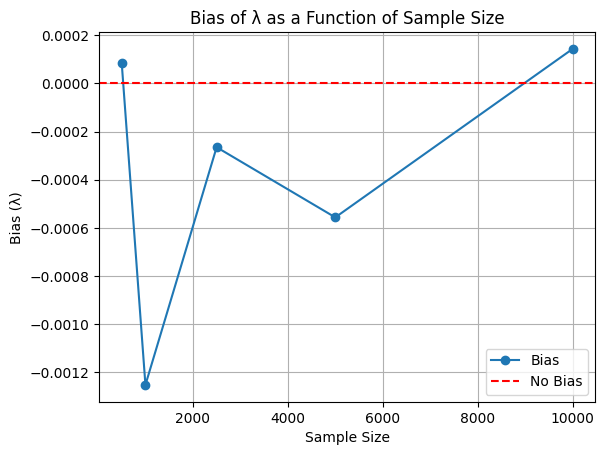

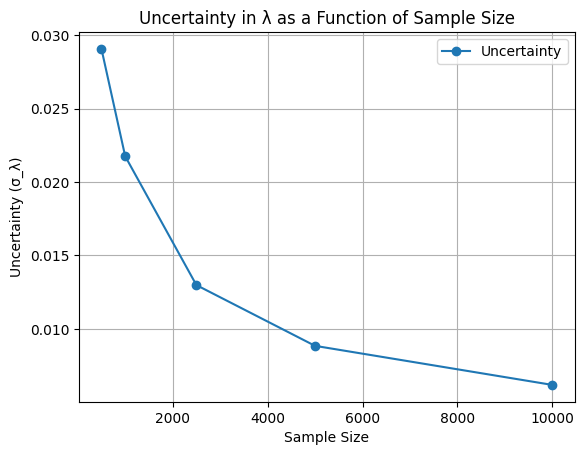


Sample Size: 500
  mu: 2.9980
  sigma: 0.2988
  beta: 1.0137
  m: 1.4675
  lambda_s: 0.3001
  mu_b: 0.0149
  sigma_b: 2.4942
  f_signal: 0.6016
  N_expected: 499.8314

Sample Size: 1000
  mu: 3.0012
  sigma: 0.2990
  beta: 1.0301
  m: 1.3960
  lambda_s: 0.2987
  mu_b: 0.0080
  sigma_b: 2.4737
  f_signal: 0.5997
  N_expected: 1000.3581

Sample Size: 2500
  mu: 3.0014
  sigma: 0.2981
  beta: 1.0060
  m: 1.4297
  lambda_s: 0.2997
  mu_b: 0.0100
  sigma_b: 2.4922
  f_signal: 0.5995
  N_expected: 2496.1300

Sample Size: 5000
  mu: 2.9998
  sigma: 0.3001
  beta: 1.0143
  m: 1.4007
  lambda_s: 0.2994
  mu_b: 0.0061
  sigma_b: 2.4991
  f_signal: 0.5994
  N_expected: 5001.4187

Sample Size: 10000
  mu: 3.0001
  sigma: 0.3003
  beta: 0.9995
  m: 1.4114
  lambda_s: 0.3001
  mu_b: -0.0016
  sigma_b: 2.5020
  f_signal: 0.6006
  N_expected: 9990.7470


In [ ]:
def bootstrap_study(bounds, true_lambda, params, n_trials=250):
    """
    Perform a bootstrap simulation study to evaluate bias and uncertainty in the fitted `lambda` parameter.

    Args:
        bounds: Parameter bounds for the fit (excluding N_expected).
        true_lambda: True value of the decay constant (λ) to compare bias.
        params: True model parameters for sampling.
        n_trials: Number of bootstrap trials for each sample size.

    Returns:
        results: A dictionary containing biases, uncertainties, sample sizes, and average parameters.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": [],
        "average_parameters": {},  # To store average fitted parameters for each sample size
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []
        fitted_parameters = {param: [] for param in bounds.keys()}  # Collect all fitted params

        for _ in range(n_trials):
            # Generate Poisson variation of sample size
            poisson_sample_size = np.random.poisson(sample_size)

            # Generate samples using the new sampling function
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            # Define initial guesses for the fit
            initial_guess = {
                "mu": 3.0,        # True value
                "sigma": 0.35,    # True value
                "beta": 1.2,      # True value
                "m": 1.5,         # True value
                "lambda_s": 0.3,  # True value
                "mu_b": 0.0,      # True value
                "sigma_b": 2.5,   # True value
                "f_signal": 0.5,  # True value
                "N_expected": poisson_sample_size,  # Poisson variation
            }

            # Dynamically set bounds for N_expected based on the Poisson sample size
            dynamic_bounds = bounds.copy()
            dynamic_bounds["N_expected"] = (
                0.95 * poisson_sample_size,
                1.05 * poisson_sample_size,
            )

            # Perform fit using the new fitting function
            fit_result = perform_fit(x_samples, y_samples, dynamic_bounds, initial_guess)

            # Collect fitted lambda value and other parameters if the fit converged
            if fit_result["converged"]:
                fitted_lambdas.append(fit_result["parameters"]["lambda_s"])
                for param in fit_result["parameters"]:
                    fitted_parameters[param].append(fit_result["parameters"][param])

        # Calculate bias and uncertainty for the current sample size
        mean_lambda = np.mean(fitted_lambdas)
        std_lambda = np.std(fitted_lambdas)
        bias = mean_lambda - true_lambda

        # Store average fitted parameters for this sample size
        avg_params = {param: np.mean(values) for param, values in fitted_parameters.items()}
        results["average_parameters"][sample_size] = avg_params

        # Store results
        results["sample_size"].append(sample_size)
        results["mean_lambda"].append(mean_lambda)
        results["std_lambda"].append(std_lambda)
        results["bias"].append(bias)

        print(f"Sample Size: {sample_size}, Bias: {bias:.4f}, Uncertainty: {std_lambda:.4f}")

    return results


def plot_bootstrap_results(results):
    """
    Plot the bias and uncertainty as functions of sample size.
    """
    sample_sizes = results["sample_size"]
    biases = results["bias"]
    uncertainties = results["std_lambda"]

    # Plot bias vs sample size
    plt.figure()
    plt.plot(sample_sizes, biases, marker="o", label="Bias")
    plt.axhline(0, color="r", linestyle="--", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (λ)")
    plt.title("Bias of λ as a Function of Sample Size")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot uncertainty vs sample size
    plt.figure()
    plt.plot(sample_sizes, uncertainties, marker="o", label="Uncertainty")
    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (σ_λ)")
    plt.title("Uncertainty in λ as a Function of Sample Size")
    plt.legend()
    plt.grid()
    plt.show()


def report_average_parameters(results):
    """
    Print the average fitted parameters for each sample size.
    """
    for sample_size, avg_params in results["average_parameters"].items():
        print(f"\nSample Size: {sample_size}")
        for param, value in avg_params.items():
            print(f"  {param}: {value:.4f}")


# Define bounds for the parameters
bounds = {
    "mu": (2.8, 3.2),          # Reasonable range around the true value of 3
    "sigma": (0.2, 0.4),       # Narrow range around the true value of 0.3
    "beta": (0.8, 1.5),        # Close to the true value of 1
    "m": (1.0, 2.0),           # Narrow around the true value of 1.4
    "lambda_s": (0.2, 0.5),    # Includes the true value of 0.3
    "mu_b": (-0.1, 0.1),       # Close to the true value of 0
    "sigma_b": (2.0, 3.0),     # Around the true value of 2.5
    "f_signal": (0.3, 0.9),    # Includes the true value of 0.6
    "N_expected": (95000, 105000),  # Adjusted dynamically per trial
}

# Perform the bootstrap study
true_lambda = 0.3  # True decay constant
params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # True model parameters for sampling
results = bootstrap_study(bounds, true_lambda, params)

# Plot results
plot_bootstrap_results(results)

# Report average parameters
report_average_parameters(results)


Sample Size: 500, Bias: 0.0412, Uncertainty: 0.0234
Sample Size: 1000, Bias: 0.0399, Uncertainty: 0.0146
Sample Size: 2500, Bias: 0.0405, Uncertainty: 0.0094
Sample Size: 5000, Bias: 0.0404, Uncertainty: 0.0072
Fit in X failed on attempt 1: Fit did not converge
Fit in X failed on attempt 2: Fit did not converge
Fit in X failed on attempt 3: Fit did not converge
Fit in X did not converge after maximum retries. Skipping iteration.
Sample Size: 10000, Bias: 0.0401, Uncertainty: 0.0049
Sample Size: 30000, Bias: 0.0399, Uncertainty: 0.0030


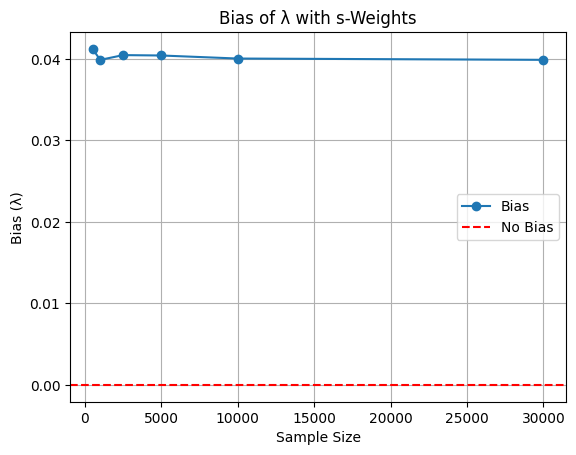

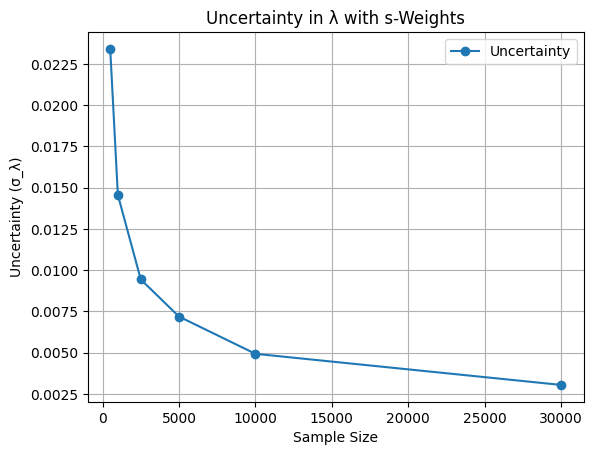

In [56]:
from iminuit import Minuit
import numpy as np

def fit_X(x_samples, bounds, initial_guess):
    """
    Perform an extended likelihood fit in the X dimension only.

    Args:
        x_samples (array): Array of X samples.
        bounds (dict): A dictionary of parameter bounds for the fit.
        initial_guess (dict): A dictionary of initial parameter guesses.

    Returns:
        dict: Fitted parameters, uncertainties, and s-weights for each sample.
    """
    def negative_log_likelihood(mu, sigma, beta, m, f_signal, N_expected):
        try:
            # Precompute normalization constant for g_s(X)
            g_s_norm = crystal_ball_normalization_truncated(mu, sigma, beta, m, lower=0, upper=5)

            # Compute the signal and background PDFs
            signal_pdf = g_s_vectorized(x_samples, mu, sigma, beta, m, g_s_norm)
            background_pdf = g_b_vectorized(x_samples)
            
            # Combine signal and background PDFs
            pdf_vals = f_signal * signal_pdf + (1 - f_signal) * background_pdf

            # Ensure numerical stability
            pdf_vals += 1e-10

            # Extended likelihood terms
            log_likelihood = (
                -N_expected
                + len(x_samples) * np.log(N_expected)
                + np.sum(np.log(pdf_vals))
            )

            return -log_likelihood
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit for the fit
    m = Minuit(negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Extract the fitted parameters
    params = {name: value for name, value in zip(m.parameters, m.values)}

    # Calculate s-weights
    g_s_norm = crystal_ball_normalization_truncated(
        params["mu"], params["sigma"], params["beta"], params["m"], lower=0, upper=5
    )
    signal_pdf = g_s_vectorized(x_samples, params["mu"], params["sigma"], params["beta"], params["m"], g_s_norm)
    background_pdf = g_b_vectorized(x_samples)
    s_weights = (params["f_signal"] * signal_pdf) / (
        params["f_signal"] * signal_pdf + (1 - params["f_signal"]) * background_pdf
    )

    return {
        "parameters": params,
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)},
        "s_weights": s_weights
    }

def fit_Y_weighted(y_samples, s_weights, bounds, initial_guess):
    """
    Perform a weighted fit in the Y dimension using s-weights.

    Args:
        y_samples (array): Array of Y samples.
        s_weights (array): Array of s-weights.
        bounds (dict): Bounds for the fit.
        initial_guess (dict): Initial guesses for the fit.

    Returns:
        dict: Fitted parameters and uncertainties for λ.
    """
    def weighted_negative_log_likelihood(lambda_s):
        try:
            # Compute the signal PDF h_s(Y)
            signal_pdf = h_s_vectorized(y_samples, lambda_s)

            # Weighted likelihood
            weighted_likelihood = s_weights * np.log(signal_pdf + 1e-10)
            return -np.sum(weighted_likelihood)
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit
    m = Minuit(weighted_negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Return the results
    return {
        "parameters": {name: value for name, value in zip(m.parameters, m.values)},
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)}
    }
    
def bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params, n_trials=250, max_retries=3):
    
    """
    Perform a bootstrap simulation study with Poisson variation on sample size.

    Args:
        bounds_X: Parameter bounds for the fit in X.
        bounds_Y: Parameter bounds for the fit in Y.
        true_lambda: True value of the decay constant λ to compare bias.
        params: True model parameters for sampling.
        n_trials: Number of bootstrap trials for each sample size.
        max_retries: Maximum number of retries for the fit in X.

    Returns:
        results: A dictionary containing biases, uncertainties, and sample sizes.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000, 30000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": []
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []

        for _ in range(n_trials):
            # Apply Poisson variation to the sample size
            poisson_sample_size = np.random.poisson(sample_size)

            # Generate samples
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            # Retry logic for the fit in X
            fit_X_result = None
            for attempt in range(max_retries):
                try:
                    # Fit in X
                    initial_guess_X = {
                        "mu": 3.1,        # Close to true value
                        "sigma": 0.32,     # True value
                        "beta": 0.9,      # True value
                        "m": 1.5,         # True value
                        "f_signal": 0.7,  # True value
                        "N_expected": poisson_sample_size  # Match initial guess to Poisson variation
                    }

                    # Dynamically set bounds for N_expected based on the Poisson sample size
                    dynamic_bounds_X = bounds_X.copy()
                    dynamic_bounds_X["N_expected"] = (
                        0.95 * poisson_sample_size,
                        1.05 * poisson_sample_size
                    )

                    # Perform the fit in X
                    fit_X_result = fit_X(x_samples, dynamic_bounds_X, initial_guess_X)
                    break  # Exit retry loop if fit succeeds

                except ValueError as e:
                    print(f"Fit in X failed on attempt {attempt + 1}: {e}")
                    # Perturb initial guesses slightly for the next attempt
                    initial_guess_X = {
                        k: v * (1 + 0.1 * np.random.uniform(-1, 1))
                        for k, v in initial_guess_X.items()
                    }

            if fit_X_result is None:
                print("Fit in X did not converge after maximum retries. Skipping iteration.")
                continue  # Skip this iteration if fit in X fails

            try:
                # Use the s-weights from the successful fit in X
                s_weights = fit_X_result["s_weights"]

                # Fit in Y using s-weights
                initial_guess_Y = {"lambda_s": 0.3}
                fit_Y_result = fit_Y_weighted(y_samples, s_weights, bounds_Y, initial_guess_Y)

                # Collect the fitted λ value
                fitted_lambdas.append(fit_Y_result["parameters"]["lambda_s"])

            except ValueError as e:
                print(f"Fit in Y failed: {e}")
                continue  # Skip this iteration if fit in Y fails

        # Calculate bias and uncertainty for the current sample size, if any fits succeeded
        if fitted_lambdas:
            mean_lambda = np.mean(fitted_lambdas)
            std_lambda = np.std(fitted_lambdas)
            bias = mean_lambda - true_lambda

            # Store results
            results["sample_size"].append(sample_size)
            results["mean_lambda"].append(mean_lambda)
            results["std_lambda"].append(std_lambda)
            results["bias"].append(bias)

            print(f"Sample Size: {sample_size}, Bias: {bias:.4f}, Uncertainty: {std_lambda:.4f}")
        else:
            print(f"No successful fits for sample size {sample_size}. Results will not be recorded.")

    return results

def plot_results(results):
    sample_sizes = results["sample_size"]
    biases = results["bias"]
    uncertainties = results["std_lambda"]

    # Plot bias
    plt.figure()
    plt.plot(sample_sizes, biases, marker="o", label="Bias")
    plt.axhline(0, color="r", linestyle="--", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (λ)")
    plt.title("Bias of λ with s-Weights")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot uncertainty
    plt.figure()
    plt.plot(sample_sizes, uncertainties, marker="o", label="Uncertainty")
    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (σ_λ)")
    plt.title("Uncertainty in λ with s-Weights")
    plt.legend()
    plt.grid()
    plt.show()

# Define bounds for X and Y fits
bounds_X = {
    "mu": (2.9, 3.1),         # Wider range for mu
    "sigma": (0.1, 0.5),      # Allow more flexibility for sigma
    "beta": (0.5, 2.0),       # Include a wider range for beta
    "m": (1.0, 3.0),          # Expand m range
    "f_signal": (0.1, 1.0),   # Include full range for f_signal
    "N_expected": (400, 600)  # Allow variation in expected sample size
}

bounds_Y = {
    "lambda_s": (0.2, 0.5)
}

# Run bootstrap study
true_lambda = 0.3
params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # True model parameters
results = bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params)

# Plot results
plot_results(results)
